In [1]:
import numpy as np
from scipy.integrate import quad, nquad
from scipy.optimize import fsolve, root
import matplotlib.pyplot as plt

def varIntegrand(z, prev_q):
    return np.tanh(np.sqrt(prev_q) * z)**2 * 1.0/np.sqrt(2.0 * np.pi) * np.exp(-(z**2)/2.0)

def corrIntegrand(z1, z2, prev_c, qstar):
#     if prev_c > 1: prev_c = 1
    u1 = np.sqrt(qstar) * z1
    u2 = np.sqrt(qstar) * (prev_c * z1 + np.sqrt(np.absolute(1-prev_c**2)) * z2)
    D1 = np.exp(-(z1**2)/2.0) * 1.0/np.sqrt(2.0 * np.pi)
    D2 = np.exp(-(z2**2)/2.0) * 1.0/np.sqrt(2.0 * np.pi)
    return np.tanh(u1) * np.tanh(u2) * D1 * D2

# Sets q= q* and numerically solves
def varianceMap(q, weightVar, n_hid, n_dim, dataVar, dataMean, biasVar):
    return weightVar * quad(varIntegrand, -np.inf, np.inf, args=(q))[0] \
            + weightVar * (n_dim/n_hid) * (dataVar + dataMean**2) + biasVar - q
    
# Used for numerically solving for c*
def corrMap(c, weightVar, n_hidden, n_dim, dataVar, dataMean, biasVar):
    qStar = fsolve(varianceMap, weightVar, args=(weightVar , n_hidden, n_dim, dataVar, dataMean, biasVar))[0]
    return (1/qStar) * ( weightVar \
            * nquad(corrIntegrand, [[-np.inf, np.inf],[-np.inf, np.inf]], args=(c, qStar))[0] \
            + weightVar* (n_dim/n_hidden) * (dataVar + dataMean**2) + biasVar) - c

def findQStar(weightVar, n_hidden, n_dim, dataVar, dataMean, biasVar):
    return fsolve(varianceMap, weightVar, args=(weightVar , n_hidden, n_dim, dataVar, dataMean, biasVar))[0]

def findCStar(weightVar, n_hidden, n_dim, dataVar, dataMean, biasVar):
    return fsolve(corrMap, 0.5, args=(weightVar, n_hidden, n_dim, dataVar, dataMean, biasVar))

def chiIntegrand(z, qStar):
    Dz = 1.0/np.sqrt(2.0 * np.pi) * np.exp(-(z**2)/2.0)
    phiPrime = (1/np.cosh(np.sqrt(qStar) * z))**2 # Derivative of tanh()
    return phiPrime**2 * Dz

def chi(weightVar, qStar):
    return weightVar * quad(chiIntegrand, -np.inf, np.inf, args=(qStar))[0]

def xiqIntegrand(z, weightVar, qStar):
    Dz = np.exp(-(z**2)/2.0) * 1.0/np.sqrt(2.0 * np.pi)
    phi = np.tanh(np.sqrt(qStar)*z)
    phiDoublePrime = -2.0 * np.tanh(np.sqrt(qStar)*z) * 1/(np.cosh(np.sqrt(qStar)*z))**2
    return Dz * phiDoublePrime * phi

def xiq(weightVar, qStar):
    return 1/(-np.log(chi(weightVar, qStar) + weightVar * quad(xiqIntegrand, -np.inf, np.inf, args=(weightVar, qStar))[0]))

def xicIntegrand(z1, z2, qStar, cStar):
    u1 = np.sqrt(qStar) * z1
    u2 = np.sqrt(qStar) * (cStar * z1 + np.sqrt(np.absolute(1-cStar**2)) * z2)
    D1 = np.exp(-(z1**2)/2.0) * 1.0/np.sqrt(2.0 * np.pi)
    D2 = np.exp(-(z2**2)/2.0) * 1.0/np.sqrt(2.0 * np.pi)
    phiPrime1 = (1/np.cosh(u1))**2
    phiPrime2 = (1/np.cosh(u2))**2 # Derivative of tanh()
    return D1 * D2 * phiPrime1 * phiPrime2

def xic(weightVar, qStar, cStar):
    return 1/(-np.log(weightVar*nquad(xicIntegrand, [[-np.inf, np.inf],[-np.inf, np.inf]], args=(qStar, cStar))[0]))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in cosh


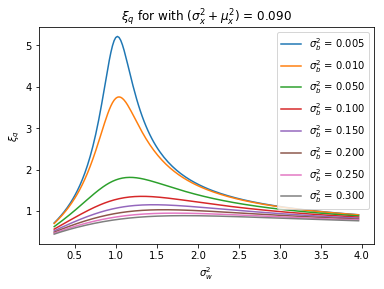

In [2]:
delta = 0.01
weightStd = np.arange(0.5, 2.0, delta)
weightVar = [i**2 for i in weightStd]
biasVar = [0.005, 0.01, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3]

n_hidden = 256
n_dim = 3
dataVar = 0.089609815596183001
# dataVar = 0
dataMean = 0.0

for b in biasVar:
    output = []

    for w in weightVar:
        qStar = findQStar(w, n_hidden, n_dim, dataVar, dataMean, b)
        output.append(xiq(w, qStar))

    plt.plot(weightVar, output, label=r'$\sigma_b^2$ = %.3f' % b)
    plt.xlabel(r'$\sigma_w^2$')
    plt.ylabel(r'$\xi_q$')

plt.title(r'$\xi_q$ for with $(\sigma_x^2 + \mu_x^2)$ = %.3f' % (dataVar + dataMean**2))
plt.legend()
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in cosh
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in cosh


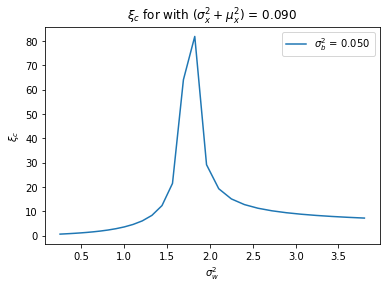

In [12]:
delta = 0.05
weightStd = np.arange(0.5, 2.0, delta)
weightVar = [i**2 for i in weightStd]
biasVar = [0.05]

n_hidden = 128
n_dim = 3
dataVar = 0.089609815596183001
# dataVar = 0
dataMean = 0.0

for b in biasVar:
    output = []

    for w in weightVar:
        qStar = findQStar(w, n_hidden, n_dim, dataVar, dataMean, b)
        cStar = findCStar(w, n_hidden, n_dim, dataVar, dataMean, b)
        output.append(xic(w, qStar, cStar))

    plt.plot(weightVar, output, label=r'$\sigma_b^2$ = %.3f' % b)
    plt.xlabel(r'$\sigma_w^2$')
    plt.ylabel(r'$\xi_c$')

plt.title(r'$\xi_c$ for with $(\sigma_x^2 + \mu_x^2)$ = %.3f' % (dataVar + dataMean**2))
plt.legend()
plt.show()